In [1]:
import json
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import tensorflow_text
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'
from scipy import spatial
import seaborn as sns
from rouge_score import rouge_scorer

In [2]:
# text ставим в начале
! pip install tensorflow_text
!pip install tensorflow_hub

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [39]:
!pip install seaborn

     |████████████████████████████████| 292 kB 1.7 MB/s            
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [48]:
! pip install rouge-score

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [1]:
! nvidia-smi

Thu Jun  9 21:15:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 455.23.05    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1F:00.0 Off |                    0 |
| N/A   40C    P0    71W / 300W |  31911MiB / 32510MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:20:00.0 Off |                    0 |
| N/A   

In [68]:
with open('augmentations.json', 'r') as f:
    data = json.load(f)

In [69]:
for i, key in enumerate(data.keys()):
    source = key
    augmented = data[key]
    if i == 1: 
        break 

In [70]:
source

"Isn't it a compliance issue?"

In [71]:
augmented

["Isn't it compliance issue?",
 "Isn't it a compliance issue?",
 "Isn't it a compliance issue?",
 "Doesn't it come as a compliance issue too?",
 "It isn't compliance issue?",
 "Isn't it a compliance issue?",
 'And is that any compliance related issues?',
 "Isn't it a compliance issue?",
 "Isn't it a compliance issue?",
 "Isn't it a compliance issue?",
 "Isn't it a compliance issue?",
 "Isn't it a compliance issue?",
 "Doesn't it say compliance, as there are millions of different websites out there?",
 "Isn't it a compliance issue?",
 "Isn't it a compliance issue?",
 "Isn't it a compliance issue?",
 'Is it not a compliance issue?',
 "Isn't it a compliance issue?",
 "Isn't it a compliance issue?",
 "Isn't it a compliance issue?",
 "Isn't it compliance issue?",
 "Isn't it a compliance issue?",
 'Is it not a compliance issue?',
 '" Is it not a compliance issue?\' \'\'',
 'Is it not a compliance issue ;???',
 'And wait...is it not just compliance?',
 "Isn't it a compliance issue?",
 'Can yo

As we can see from task data, there are two main problems:
- Presence of the augmented sentences which a very close to the origin 
- Presence of the augmented sentences practically unrelated to the origin sentences

That's why we a going to use two metrics - ROUGE-L as the metric of difference in order to reduce the share of the similar sentances in augmented data and cosine similarity between MUSE embeddings in order to remove sentences with different meaning   

In [82]:
# Function which calculate cossine similarity between source sentance and augemented sentances
muse = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

def muse_embeddings(source, aug, muse):
    aug_embeddings = muse(aug)
    aug_embeddings = np.array(aug_embeddings).tolist()
    source_embedding = muse(source)
    source_embedding = np.array(source_embedding).tolist()[0]
    
    return source_embedding, aug_embeddings


def calculate_cossine_sim(source, augmented):
    result = []
    for elem in augmented:
        cossine_sim = 1 - spatial.distance.cosine(source, elem)
        result.append(cossine_sim)
    return result

embeddings = muse_embeddings(source, augmented, muse)
cosine_sim = calculate_cossine_sim(embeddings[0], embeddings[1])

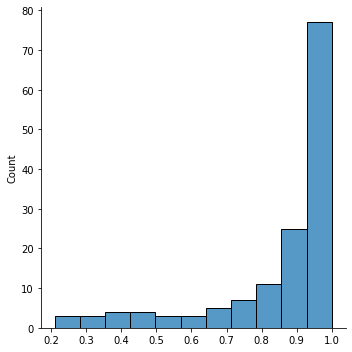

In [83]:
sns.displot(cossine_sim)

As we can see on the displot there are a lot of sentances with the low similariry to the origin sentance
We will remove sentances with the similarity less then 0.7(0.7 is a hyperparameter, must be chosen based on expert judgment)

In [77]:
def filter_unsimilar(augmented, cosine_sim, treshold=0.7):
    augmented = list(zip(augmented, cosine_sim))
    augmented = list(filter(lambda x:  x[1] >treshold, augmented))
    augmented = list(map(lambda x: x[0], augmented))
    return augmented

augmented = filter_unsimilar(augmented, cosine_sim)

# ROUGE-L calculation

In [78]:
def rougel_calculation(source, augmented):
    result = [] 
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)
    for elem in augmented:
        scores = scorer.score(source, elem)
        result.append(scores['rougeL'].fmeasure)
    return result

rougel = rougel_calculation(source, augmented)


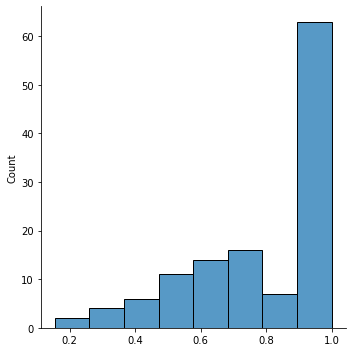

In [79]:
sns.displot(rougel)

According to the plot sentences with the ROUGE-L f-meause bigger then 0.9 will be removed, beacause they are to clouse to origin sentances

In [80]:
def filter_too_similar(augmented, rougel, treshold=0.9):
    augmented = list(zip(augmented, rougel))
    augmented = list(filter(lambda x:  x[1] < treshold, augmented))
    augmented = list(map(lambda x: x[0], augmented))
    return augmented

augmented = filter_too_similar(augmented, rougel)


In [81]:
set(augmented)

{'" Is it not a compliance issue?\' \'\'',
 '" It would be fair to sayIsn\'t it a compliance issue\'’? And',
 'And is that any compliance related issues?',
 'And wait...is it not just compliance?',
 "Are you sure it's a compliance issue?",
 "But's it a compliance issue?",
 'Does it not have a compliance issue?',
 'Does it not really pose a compliance issue?',
 "Doesn't compliance issue here really come into play?",
 "Doesn't it come as a compliance issue too?",
 "Doesn't it come at a compliance issue?",
 "Doesn't it just include a compliance issue?",
 "Doesn't it pose a compliance issue?",
 "Doesn't that refer to compliance?",
 "How isn't that a compliance issue?",
 "Is doesn't it a compliance issue?",
 "Is doesn't it a compliance issue? ",
 'Is it a compliance issue too?',
 'Is it a compliance issue?',
 'Is it actually a Compliance issue then?',
 'Is it is not it the compliance issue?',
 'Is it just compliance issues?',
 'Is it non quo is a compliance issue?',
 'Is it not a compliance

# If I had more time:
I would run an iterative improvement of the augmentation model. On the first step the dataset of source sentances with the maximum level of deversity (dispesion of cosine similarity between MUSE embeddings) will be formed . Then huge amount of augmented phrases will be generated, after that the obtained phrases is fileterd according to the above mentioned procedured. At the end pure(unfine-tuned model) is fine-tuned with using of obtained data. The last three stages is repeated until the a good result is got.

# Full solution in the file postprocessing.py